# Capstone week 4 & 5 Assignment: Toronto vs Manhaten

### in this Program we will explore the venues data from both Toronto, and Manhaten to give an insight what is the best business opporunity to invest in.

### First we will examine the top 10 venues in each city.
### Second we will plot the clusters of venues in both cities and use map clusstering to give a smooth visual map

#### we will start by importing the libraries to work with

In [357]:
#!pip3 install lxml
import json
from pandas.io.json import json_normalize
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
#!pip install geopy
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
#!pip install sklearn
from sklearn.cluster import KMeans
#!pip install folium
import folium

print ('libraries imported')

libraries imported


#### get Toronoto data

In [335]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=bs(url,'lxml')
table = str(soup.table)


In [377]:
toronto_df = pd.read_html(table)
toronto_df=toronto_df[0]
toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### cleanse the data from Toronto

In [378]:
# drop the 'Not assigned' values in Borough column
dropValues = toronto_df[ toronto_df['Borough'] == 'Not assigned' ].index
toronto_df.drop(dropValues , inplace=True)

# join neghibours with same postal area code
# please note that the data is already joined from wikipedia so the following code is
# not necessary
toronto_df = toronto_df.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
toronto_df.reset_index(inplace=True)

# changin the not assigned value in Neighbors with the corresponding value in Borough
toronto_df['Neighbourhood'] = np.where(toronto_df['Neighbourhood'] == 'Not assigned',
                                       toronto_df['Borough'], toronto_df['Neighbourhood'])

toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [339]:
toronto_df.shape

(103, 3)

####  Read the Lat,Long and join it to Toronto data frame

In [379]:
lon_lat = pd.read_csv('http://cocl.us/Geospatial_data')
toronto_df=pd.merge(toronto_df,lon_lat,on='Postal Code')

In [380]:
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


#### Selecting Toronto Boroughs to work with

In [381]:
toronto_df2=toronto_df.loc[toronto_df['Borough'].str.contains('Toronto',regex=False)]
toronto_df2.reset_index(inplace = True, drop = True)
toronto_df2.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


#### get geopostal data, and accessing forsquare to get venues 

In [345]:
address = 'Toronto, Canada'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [346]:
CLIENT_ID = 'WRJXKYCSIIBRV0GXVBK0UIXBM3GZVUCUJ55WMRASFE2CV4BN' # your Foursquare ID
CLIENT_SECRET = 'RRMVJO05UDXJ2MCWJL0KXDWSHVUTP13E0G42ERYUMICDP520' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WRJXKYCSIIBRV0GXVBK0UIXBM3GZVUCUJ55WMRASFE2CV4BN
CLIENT_SECRET:RRMVJO05UDXJ2MCWJL0KXDWSHVUTP13E0G42ERYUMICDP520


In [347]:
neighborhood_latitude = toronto_df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df2.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Downtown Toronto are 43.6542599, -79.3606359.


In [167]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [168]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [382]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]



C:\Users\Hassan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [383]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


In [110]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [236]:
Tornoto_venues = getNearbyVenues(names=toronto_df2['Neighbourhood'],
                                   latitudes=toronto_df2['Latitude'],
                                   longitudes=toronto_df2['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [384]:
Tornoto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


## Now that we have toronto venues data frame all set.
## I have already prepared a similar data frame for manhaten venues
## and since both are the same process I decided just to import a csv file
## that contains the data instead of repeating the above code to optimize the program

In [386]:
manhattan_venues=pd.read_csv('manhattan_venues.csv')
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


## get the top 10 venues of Toronto

In [325]:
d1=pd.DataFrame(Tornoto_venues.groupby('Venue Category')['Neighborhood'].count())
d1.sort_values('Neighborhood',ascending=False,inplace=True)
d1.rename(columns = {'Neighborhood':'Total'}, inplace = True)
toronto_top10=d1.head(10)
toronto_top10['Rate'] = (toronto_top10.Total / toronto_top10.Total.sum())
toronto_top10['Rate']=toronto_top10['Rate'].apply(pd.to_numeric)
print('Top 10 venues in Toronto')
toronto_top10

Top 10 venues in Toronto


C:\Users\Hassan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Hassan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Total,Rate
Venue Category,,
Coffee Shop,156,0.293233
Café,89,0.167293
Restaurant,55,0.103383
Hotel,38,0.071429
Italian Restaurant,38,0.071429
Park,36,0.067669
Japanese Restaurant,33,0.062030
Bakery,30,0.056391
Bar,29,0.054511


## get top 10 venues of Manhaten

In [327]:
d2=pd.DataFrame(manhattan_venues.groupby('Venue Category')['Neighborhood'].count())
d2.sort_values('Neighborhood',ascending=False,inplace=True)
d2.rename(columns = {'Neighborhood':'Total'}, inplace = True) 
manhaten_top10=d2.head(10)
manhaten_top10['Rate'] = (manhaten_top10.Total / manhaten_top10.Total.sum())
manhaten_top10['Rate']=manhaten_top10['Rate'].apply(pd.to_numeric)
print('Top 10 venues in Manhaten')
manhaten_top10

Top 10 venues in Manhaten


C:\Users\Hassan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Hassan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Total,Rate
Venue Category,,
Coffee Shop,147,0.178398
Italian Restaurant,128,0.155340
Café,80,0.097087
Bakery,74,0.089806
Pizza Place,73,0.088592
Park,69,0.083738
American Restaurant,69,0.083738
Hotel,68,0.082524
Cocktail Bar,58,0.070388


## Now let plot the top 10 venues of both cities to get a clear view of what is the best business 
## to invest in

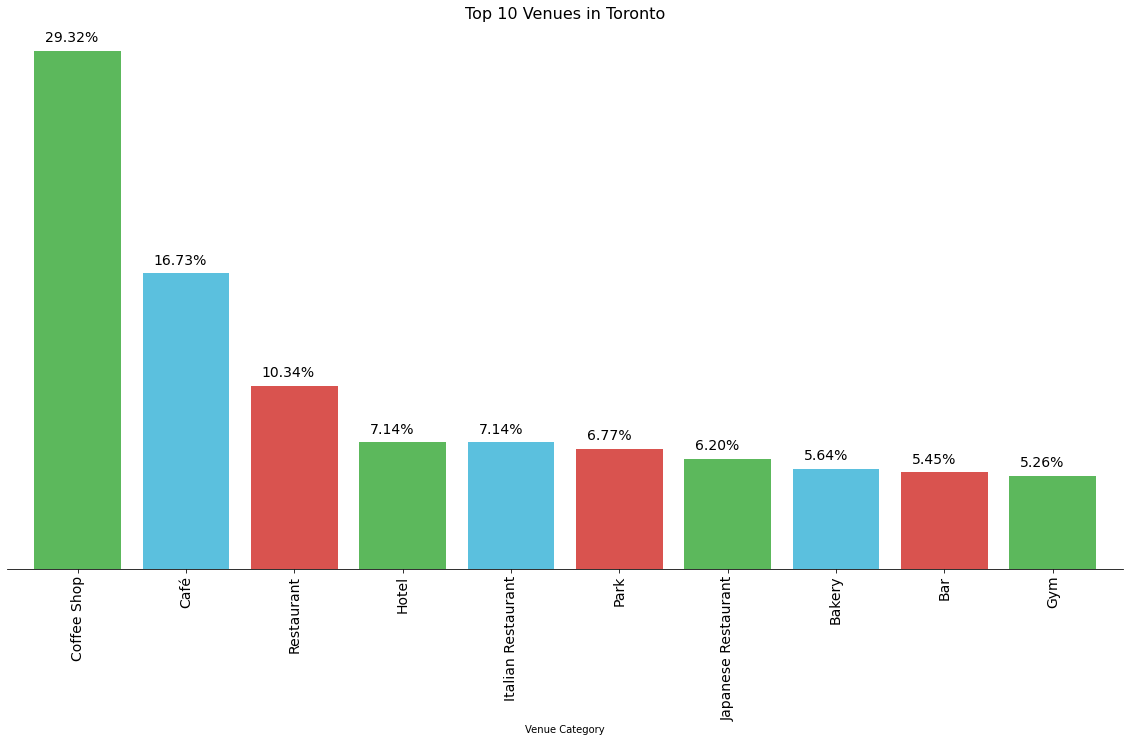

In [388]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
ax = toronto_top10['Rate'].plot(kind='bar', width=0.8, figsize=(20, 10),color=['#5cb85c','#5bc0de','#d9534f']
                    ,fontsize=14)
for p in ax.patches:
    ax.annotate("{:.02%}".format(float(p.get_height())), (p.get_x()+.1 , p.get_height()+.005),size=14)
ax.set_title('Top 10 Venues in Toronto', fontsize=16 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_visible(False)

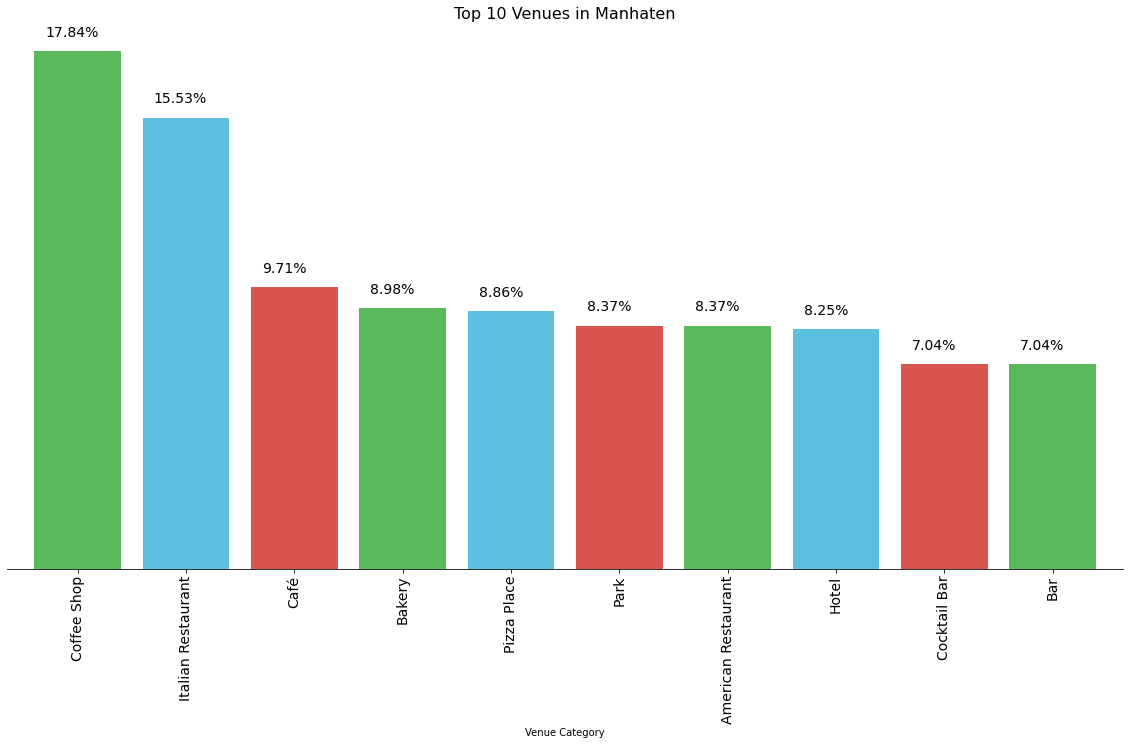

In [389]:
ax = manhaten_top10['Rate'].plot(kind='bar', width=0.8, figsize=(20, 10),color=['#5cb85c','#5bc0de','#d9534f']
                    ,fontsize=14)
for p in ax.patches:
    ax.annotate("{:.02%}".format(float(p.get_height())), (p.get_x()+.1 , p.get_height()+.005),size=14)
ax.set_title('Top 10 Venues in Manhaten', fontsize=16 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_visible(False)

# From the above grpah we can determine that:
# best investment in Toronto would be : a Coffe shop, 
# best investment in Manhaten would be : a Coffe shop
# we can see that both are same venues.
# but if we were to decide which city to invest in we would clearly see that Toronto is better based on the Rating.


# The following cells of code are data manipulation and using Kmean clustering to be able to view the venues in both cities 

In [158]:
Tornoto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,60,60,60,60,60,60
"Brockton, Parkdale Village, Exhibition Place",26,26,26,26,26,26
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,64,64,64,64,64,64
Christie,17,17,17,17,17,17
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


In [273]:
print('There are {} uniques categories.'.format(len(Tornoto_venues['Venue Category'].unique())))

There are 235 uniques categories.


In [333]:
toronto_onehot = pd.get_dummies(Tornoto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = Tornoto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

In [332]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
#toronto_grouped

In [159]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.08
1    Cocktail Bar  0.03
2        Beer Bar  0.03
3            Café  0.03
4  Farmers Market  0.03


----Brockton, Parkdale Village, Exhibition Place----
                   venue  freq
0                   Café  0.12
1         Breakfast Spot  0.08
2  Performing Arts Venue  0.08
3            Coffee Shop  0.08
4                 Bakery  0.08


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.11
1         Garden Center  0.06
2      Recording Studio  0.06
3  Fast Food Restaurant  0.06
4            Skate Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0  Airport Service  0.18
1   Airport Lounge  0.12
2      Coffee Shop  0.06
3  Harbor / Marina  0.06
4              Bar  0.06


----Central Bay Street----
                venue  f

In [122]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [331]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.head()

In [127]:
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [329]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_df2
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
#toronto_merged.sort_values(['Cluster Labels']) # check the last columns!

# View the Venues in bothe cities using Marker Cluster for eaiser map navigation.

In [367]:
from folium import plugins
address = 'Toronto, Canada'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# let's start again with a clean copy of the map of San Francisco
map_Toronto = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
groups = plugins.MarkerCluster().add_to(map_Toronto)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(toronto_merged['Latitude'],
                            toronto_merged['Longitude'],
                            toronto_merged['Neighbourhood']+'\n Cluster: '+toronto_merged['Cluster Labels'].astype(str)
                           ):
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(groups)

# display map
map_Toronto

In [ ]:
manhattan_merged=pd.read_csv('manhattan_merged')

In [376]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


# let's start again with a clean copy of the map of San Francisco
map_Manhaten = folium.Map(location = [latitude, longitude], zoom_start = 11.5)

# instantiate a mark cluster object for the incidents in the dataframe
groups = plugins.MarkerCluster().add_to(map_Manhaten)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(manhattan_merged['Latitude'],
                            manhattan_merged['Longitude'],
                            manhattan_merged['Neighborhood']+'\n Cluster: '+manhattan_merged['Cluster Labels'].astype(str)
                           ):
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(groups)

# display map
map_Manhaten